In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from mpl_toolkits.basemap import Basemap
from scipy import spatial
import math

from sklearn import neighbors, linear_model, cross_validation, svm

imgroot = 'C:/Users/lezhi/Dropbox/thesis/img/'
dataroot = 'C:/Users/lezhi/Dropbox/thesis/data/'

# Pre-processing real estate data

In [3]:
df = pd.read_csv(dataroot+'realestate2.csv', index_col=0)
df['price'] = np.array([(el[1:].replace(',','') if (not pd.isnull(el)) else np.nan) for el in df['price']]).astype(float)

In [4]:
df['val-price'] = df.apply(lambda x: x.price if pd.isnull(x.val) else x.val, axis=1)

In [5]:
df = df.dropna(subset=['lat','lng','val-price','fsz'])

In [6]:
# df = df.dropna(subset=['fsz','val-price','lat','lng'], how='any') # len = 409
df['unit_val'] = df.apply(lambda x: x['val-price'] / x.fsz, axis=1)

### exploring whether either 'construction time' or 'use' has influence on unit price distribution

In [7]:
dfgb = df.groupby('yr')
yr_df = dfgb['unit_val'].agg([np.mean, np.std])

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
C:\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


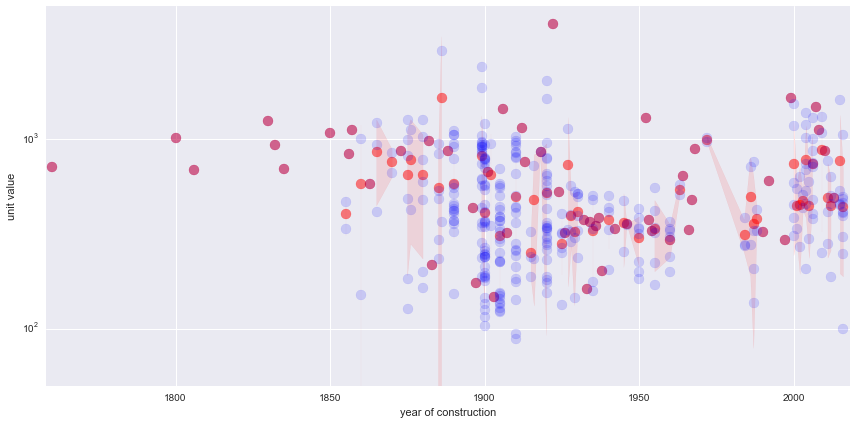

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), tight_layout=True)

mn=yr_df['mean']
std=yr_df['std']
yr=yr_df.index.values

#red
ax.scatter(yr, mn, color='r', alpha=0.5, s=100)
ax.fill_between(yr, mn-std, mn+std, color='r', alpha=0.1)

#blue
for name, group in dfgb['unit_val']:
    ax.scatter([name] * len(group), group, color='b', alpha=0.15, s=100)
    
#ax.set_xscale('symlog')
ax.set_yscale("log")
ax.set_xlim([1758,2018])
ax.set_ylim([50,5000])
    
ax.set_xlabel('year of construction')
ax.set_ylabel("unit value")

In [9]:
dfgb2 = df.groupby('use')

In [10]:
i = 0

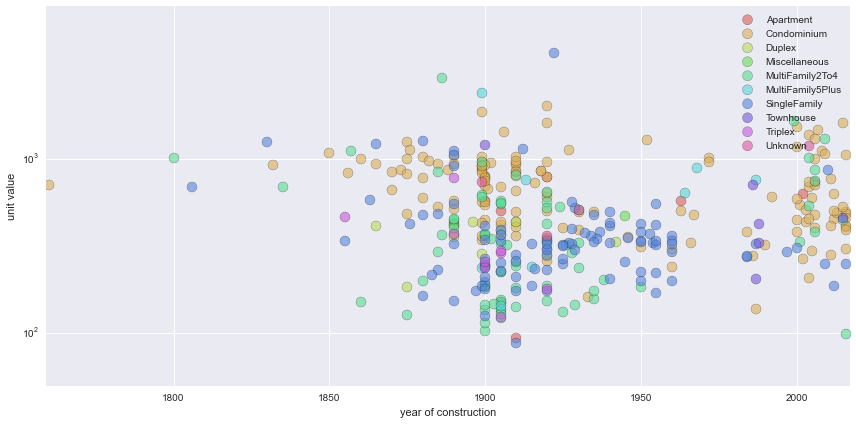

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), tight_layout=True)

mn=yr_df['mean']
std=yr_df['std']
yr=yr_df.index.values

colors = sns.color_palette("hls", 10) # cubehelix

for i, (name, group) in enumerate(dfgb2): 
    ax.scatter(group['yr'], group['unit_val'], label=name, alpha=0.6, s=100, c=colors[i])    

ax.set_yscale("log")
ax.set_xlim([1759,2017])
ax.set_ylim([50,7500])
ax.legend()
    
ax.set_xlabel('year of construction')
ax.set_ylabel("unit value")

### remove extremes

In [170]:
a = df.sort(columns='unit_val',ascending=False)
a.head(10)

fsz        lat        lng  rm     sz  \
226     1  42.346580 -71.149902 NaN  43560   
465   711  42.348849 -71.074449   3  95907   
383  1350  42.350620 -71.084790 NaN    NaN   
128   350  42.343273 -71.107422 NaN    NaN   
287   250  42.359190 -71.066670   1    260   
319   325  42.345768 -71.088190   4   9999   
492  2000  42.357723 -71.071952 NaN    NaN   
164   700  42.345450 -71.072590   4    780   
39   1599  42.347980 -71.078680 NaN    NaN   
328  1984  42.355525 -71.073379   6   1984   

                                                   url               use  \
226  http://www.zillow.com/webservice/GetDeepSearch...         Apartment   
465  http://www.zillow.com/webservice/GetDeepSearch...      SingleFamily   
383  http://www.zillow.com/webservice/GetDeepSearch...   MultiFamily2To4   
128  http://www.zillow.com/webservice/GetDeepSearch...      SingleFamily   
287  http://www.zillow.com/webservice/GetDeepSearch...  MultiFamily5Plus   
319  http://www.zillow.com/webservice/GetDeepSearch...       Condominium   
492  http://www.zillow.com/webservice/GetDeepSearch...         Apartment   
164  http://www.zillow.com/webservice/GetDeepSearch...       Condominium   
39   http://www.zillow.com/webservice/GetDeepSearch...   MultiFamily2To4   
328  http://www.zillow.com/webservice/GetDeepSearch...       Condominium   

         val    yr    price  val-price       unit_val         Y  
226      NaN   NaN   615000     615000  615000.000000  3.474383  
465  2887325  1922  2350000    2887325    4060.935302  7.354598  
383      NaN  1886  3950000    3950000    2925.925926  5.609126  
128   955274   NaN   709000     955274    2729.354286  4.652747  
287      NaN  1899   600000     600000    2400.000000  2.986921  
319   657821  1920   459000     657821    2024.064615  3.829505  
492      NaN   NaN  3995000    3995000    1997.500000 -0.259004  
164  1305098  1899   699000    1305098    1864.425714  3.367489  
39   2627717  1999   549000    2627717    1643.350219  2.665750  
328  3205252  1920  3400000    3205252    1615.550403  2.647213

In [202]:
a = df.sort(columns='unit_val',ascending=True)
a.head(10)

fsz        lat        lng  rm     sz  \
280  8855  42.306763 -71.086784 NaN  10018   
311  3525  42.349357 -71.162817  15   4323   
78   6543  42.351127 -71.149405  14   6534   
432  3700  42.314594 -71.087486 NaN   6098   
490  4470  42.294220 -71.080535  18   3484   
201  5448  42.277795 -71.096911  18   4791   
230  5151  42.286300 -71.076573  18   4721   
257  2291  42.282256 -71.084145   9   5227   
225  5267  42.310186 -71.085432  19   8712   
483  3768  42.294897 -71.084062  17   3484   

                                                   url              use  \
280  http://www.zillow.com/webservice/GetDeepSearch...     SingleFamily   
311  http://www.zillow.com/webservice/GetDeepSearch...        Apartment   
78   http://www.zillow.com/webservice/GetDeepSearch...  MultiFamily2To4   
432  http://www.zillow.com/webservice/GetDeepSearch...  MultiFamily2To4   
490  http://www.zillow.com/webservice/GetDeepSearch...  MultiFamily2To4   
201  http://www.zillow.com/webservice/GetDeepSearch...  MultiFamily2To4   
230  http://www.zillow.com/webservice/GetDeepSearch...          Triplex   
257  http://www.zillow.com/webservice/GetDeepSearch...     SingleFamily   
225  http://www.zillow.com/webservice/GetDeepSearch...  MultiFamily2To4   
483  http://www.zillow.com/webservice/GetDeepSearch...  MultiFamily2To4   

        val    yr    price  val-price    unit_val         Y  
280  778509  1910   769000     778509   87.917448 -1.196288  
311     NaN  1910   329000     329000   93.333333 -1.177537  
78      NaN  2016   649000     649000   99.189974 -1.010911  
432  381436  1900   689000     381436  103.090811 -0.999806  
490  514677  1900   659900     514677  115.140268 -0.965503  
201  668269  1905   589900     668269  122.663179 -0.944086  
230  641850  1905   225000     641850  124.606872 -1.067807  
257  289043  1900   385000     289043  126.164557 -1.038076  
225  670102  1875  1599000     670102  127.226505 -0.931095  
483  484203  1905   399999     484203  128.503981 -0.927459

In [203]:
ind = np.array([not el in [226,465,383,128,280,311,78,432] for el in df.index])
df = df[ind]

### normalize by "use"

In [204]:
df['Y'] = df.groupby('use')['unit_val'].transform(lambda x: (x - x.mean()) / x.std() )

### found a record that has wrong coordinates on Zillow...

In [22]:
a = df.sort(columns='lat',ascending=False)
print a.loc[273,'url']
a.head()
# http://www.zillow.com/homedetails/295-297-Beacon-St-UNIT-22-Boston-MA-02116/59170661_zpid/
# Current coor: 42.383911,-71.112991; Actual coor: 42.353019, -71.080864

http://www.zillow.com/webservice/GetDeepSearchResults.htm?zws-id=X1-ZWz1f9f43srdhn_5b1bv&address=295+Beacon+St&citystatezip=02116


fsz        lat        lng  rm    sz  \
248  1775  42.390362 -71.006812   7  7500   
455  3261  42.385135 -71.002222 NaN  2560   
273  1131  42.383911 -71.112991   6  1131   
299  2908  42.383732 -71.078964  12  3755   
28    900  42.383333 -71.070579   3   435   

                                                   url              use  \
248  http://www.zillow.com/webservice/GetDeepSearch...     SingleFamily   
455  http://www.zillow.com/webservice/GetDeepSearch...  MultiFamily2To4   
273  http://www.zillow.com/webservice/GetDeepSearch...  MultiFamily2To4   
299  http://www.zillow.com/webservice/GetDeepSearch...          Triplex   
28   http://www.zillow.com/webservice/GetDeepSearch...     SingleFamily   

        val    yr   price  val-price    unit_val         Y  
248  566674  1925  649900     566674  319.252958 -0.237480  
455  595365  1910  799900     595365  182.571297 -0.107252  
273  945649  1885  580000     945649  836.117595 -0.101956  
299  743523  1900  345000     743523  255.681912 -0.396566  
28   436938  1885  449000     436938  485.486667  0.099817

In [23]:
df.loc[273,'lat'] = 42.353019
df.loc[273,'lng'] = -71.080864

### visualize

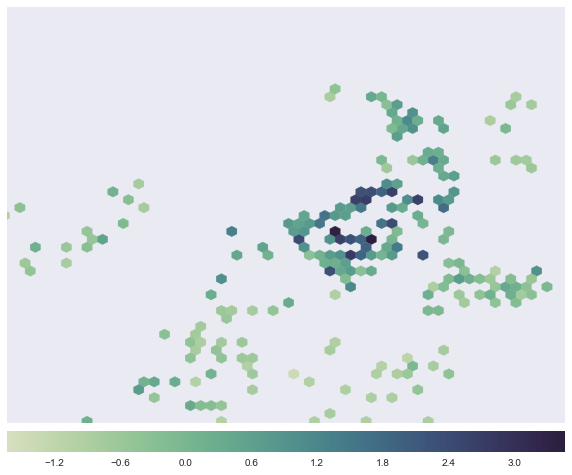

In [205]:
bounds = [-71.16197823, -71.02110553, 42.300087100000006, 42.40502692]

fig = plt.figure(figsize=(10,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(resolution = 'l', 
              epsg=4326,
              llcrnrlon = bounds[0], llcrnrlat = bounds[2], urcrnrlon = bounds[1], urcrnrlat = bounds[3])

cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True) # sns.diverging_palette(220, 20, n=7, as_cmap=True)
minval = np.min(df['Y'])
# values = [math.log(x-minval+2.7) for x in df['Y']]

map.hexbin(df['lng'].values, df['lat'].values, C=df["Y"], reduce_C_function = np.mean, gridsize = 65, cmap=cmap)

map.colorbar(location='bottom')

plt.show()

# associate property values with img locations (radius neighbor regression)

In [27]:
df_coor = pd.read_csv(dataroot+'deep_test_stats_boston.csv')[['lat','lng']]

In [28]:
df_coor.head()

lat        lng
0  42.300087 -71.073887
1  42.300087 -71.073887
2  42.300135 -71.099670
3  42.300516 -71.084763
4  42.300516 -71.084763

0.0886709458007


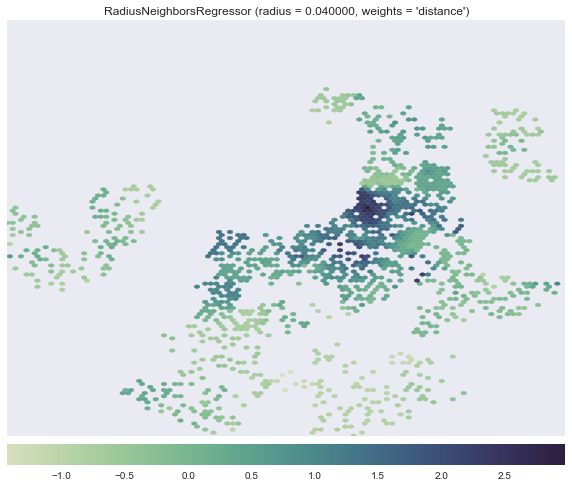

In [206]:
ma = df_coor.max() 
mi = df_coor.min()

X = (df[['lat','lng']] - 0.5*(ma + mi)) / (ma - mi)
T = (df_coor - 0.5*(ma + mi)) / (ma - mi)

y = df['Y']

# Fit regression model
radius = 0.04
n_neighbors = 2

nbrs = neighbors.NearestNeighbors(n_neighbors=1, metric='euclidean').fit(X) # radius=radius, 
distances, indices = nbrs.kneighbors(T)

distances = distances.ravel()
print np.mean(distances)
notAlone = distances < radius

T = T[notAlone]
df_coor_valid = df_coor[notAlone]

neigh = neighbors.RadiusNeighborsRegressor(radius=radius, weights='distance')
y_ = neigh.fit(X, y).predict(T)


fig = plt.figure(figsize=(10,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(resolution = 'l', 
              epsg=4326,
              llcrnrlon = bounds[0], llcrnrlat = bounds[2], urcrnrlon = bounds[1], urcrnrlat = bounds[3])

cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True) # sns.diverging_palette(220, 20, n=7, as_cmap=True)
minval = np.min(df['Y'])
values = [math.log(x-minval+2.7) for x in df['Y']]

map.hexbin(df_coor_valid['lng'].values, df_coor_valid['lat'].values, C=y_, reduce_C_function=np.mean, gridsize = 100, cmap=cmap)

map.colorbar(location='bottom')
plt.title("RadiusNeighborsRegressor (radius = %f, weights = '%s')" % (radius, 'distance'))
plt.show()


In [207]:
df_value = df_coor[notAlone]
df_value['value'] = y_
df_value.to_csv(dataroot+'value_boston.csv')

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [208]:
df_coor.index[notAlone]

Int64Index([   0,    1,    3,    4,    5,    6,    7,    8,    9,   10, 
            ...
            4883, 4903, 4907, 4908, 4909, 4914, 4915, 4916, 4958, 4971],
           dtype='int64', length=2540)

# getting visual features & find relationship with value

In [209]:
sum(notAlone)

2540

In [121]:
df_f = pd.read_csv(dataroot+'deep_features_boston.csv')
len(df_feature), len(df_coor)

(1218, 5638)

In [210]:
from sklearn import preprocessing 
df_feature = df_f[notAlone]
#df_feature[['lat','lng']] = 
df_feature = preprocessing.normalize(df_feature, norm='l2', axis=1)

In [134]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge
import time

In [211]:
X, X_test, y, y_test = cross_validation.train_test_split(df_feature, y_, test_size=0.33)

In [226]:
X_base, X_btest, y_base, y_btest = cross_validation.train_test_split(df_coor[notAlone], y_, test_size=0.33)

In [258]:
# http://scikit-learn.org/stable/auto_examples/plot_kernel_ridge_regression.html
kernel = 'linear'

train_size = len(X)
print train_size

kr = GridSearchCV(KernelRidge(kernel=kernel, gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)

t0 = time.time()
y_kr = kr.predict(X_test)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_test.shape[0], kr_predict))

1701
KRR complexity and bandwidth selected and model fitted in 58.149 s
KRR prediction for 839 inputs in 0.363 s


In [253]:
# http://scikit-learn.org/stable/auto_examples/plot_kernel_ridge_regression.html
kernel = 'rbf'

train_size = len(X_base)

krb = GridSearchCV(KernelRidge(kernel=kernel, gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
krb.fit(X_base[:train_size], y_base[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)

t0 = time.time()
y_bkr = krb.predict(X_btest)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_btest.shape[0], kr_predict))

KRR complexity and bandwidth selected and model fitted in 14.674 s
KRR prediction for 839 inputs in 0.042 s


In [246]:
kr.best_estimator_.support_.shape[0], kr.best_estimator_.coef_

AttributeError: 'KernelRidge' object has no attribute 'coef_'

In [255]:
score_bkr = krb.score(X_btest, y_btest)
score_bkr # rbf, normalized(axis = 1)

0.65328224688281433

In [259]:
score_kr = kr.score(X_test, y_test)
score_kr # rbf, normalized(axis = 1)

0.40701141968721954

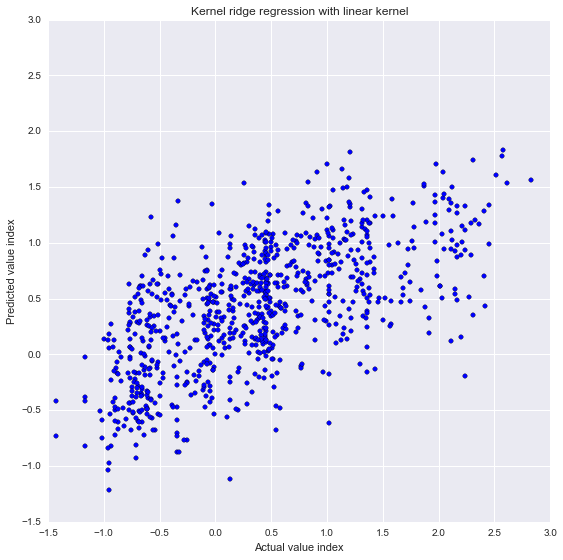

In [251]:
fig = plt.figure(figsize=(9,9))
plt.scatter(y=y_kr, x=y_test)
plt.xlim([-1.5,3])
plt.ylim([-1.5,3])

plt.xlabel('Actual value index')
plt.ylabel('Predicted value index')
plt.title('Kernel ridge regression with linear kernel')

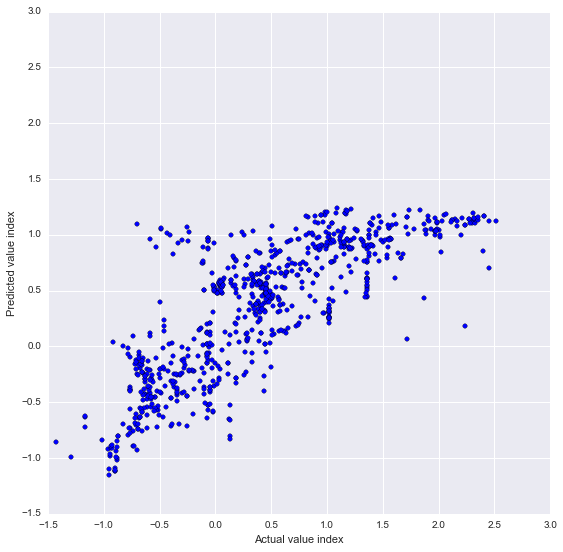

In [257]:
fig = plt.figure(figsize=(9,9))
plt.scatter(y=y_bsvr, x=y_btest)
plt.xlim([-1.5,3])
plt.ylim([-1.5,3])

plt.xlabel('Actual value index')
plt.ylabel('Predicted value index')